In [1]:
import torchvision
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

### 1. Data Preparation 

In [2]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [3]:
# PARAMS
IM_HEIGHT = 128
IM_WIDTH = 128
BATCH_SIZE = 512

In [12]:
# tranformation applied to each image (augmentation)
data_transform = torchvision.transforms.Compose([
    # torchvision.transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.CenterCrop(IM_HEIGHT),
#     torchvision.transforms.RandomRotation(degrees=60),
#     torchvision.transforms.RandomVerticalFlip(),
#     torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
])

In [13]:
# download the data 
train = torchvision.datasets.CelebA(
    root="./data/",
    transform=data_transform,
    split="train",
    download=True
)

Files already downloaded and verified


In [14]:
# create train_loader
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=BATCH_SIZE, shuffle=True)

In [15]:
x, y = next(iter(train_loader))

In [16]:
print(x.shape, y.shape)

torch.Size([512, 3, 128, 128]) torch.Size([512, 40])


In [17]:
# !nvidia-smi

##### Visualize Samples

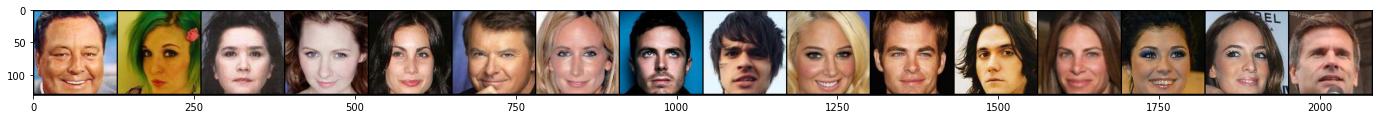

In [18]:
x, y = next(iter(train_loader))
plt.figure(figsize=(24, 24))
grid = torchvision.utils.make_grid(x[:16], nrow=32)
plt.imshow(grid.permute(1, 2, 0));

### 2. Model

In [19]:
# model params
IN_CHANNELS = 3
OUT_CHANNELS = 3
Z_DIM = 8 # if z_dim = 8 the size of Z will be 8*8 = 64

In [20]:
class VAE(nn.Module):
    
    def __init__(self, 
                 in_channels=1,
                 hidden_dims=None,
                 latent_dim=8, 
                 im_height=128, 
                 im_width=128, 
                 out_channels=1):
        
        super(VAE, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.latent_dim = latent_dim # laten dim 8, means size of Z will be 8*8
        
        
        
        # shrinking path -> encoder modules
        if hidden_dims is None:
            hidden_dims = [8, 16, 32, 64, 128, 256]
        encoder_modules = [] 
        for dim in hidden_dims:
            encoder_modules.append(self.conv_block(in_channels=in_channels, out_channels=dim, norm_dim=dim))
            in_channels = dim
        self.encoder = nn.Sequential(*encoder_modules)    
        
        
        
        # expansive path -> decoder modules
        hidden_dims.reverse()
        
        decoder_modules = []
        for i in range(len(hidden_dims) - 1):
            decoder_modules.append(self.deconv_block(in_channels=hidden_dims[i], out_channels=hidden_dims[i+1], norm_dim=hidden_dims[i+1]))
        decoder_modules.append(self.deconv_block(in_channels=hidden_dims[-1], out_channels=hidden_dims[-1], norm_dim=hidden_dims[-1]))
        decoder_modules.append(self.deconv_block(in_channels=hidden_dims[-1], out_channels=hidden_dims[-1], norm_dim=hidden_dims[-1]))
        decoder_modules.append(nn.Sequential(
            nn.Conv2d(in_channels=hidden_dims[-1], out_channels=out_channels, kernel_size=3, stride=2, padding=1),
            nn.Tanh()
        ))
        
        self.decoder = nn.Sequential(*decoder_modules)
                    
        
    def conv_block(self, in_channels, out_channels, norm_dim):
        # conv layer followed by BatchNorm and Leaky Relu to downsample the image
        conv = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(norm_dim),
                nn.LeakyReLU()
        )
        return conv
    
    def deconv_block(self, in_channels, out_channels, norm_dim):
        # deconv layer followed by a Tanh activation to upsample the image
        deconv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(norm_dim),
            nn.LeakyReLU()
            
        )
        return deconv
    
    # probablistic encoder
        
    def reparametrize(self, mu, var):
        std = torch.exp(0.5*var)
        esp = torch.rand_like(std)
        return esp*std + mu
    
    
    # probablistic decoder
    def decoder_block(self, z):
        # z.size() -> [batch_size, features]
        z = z.view(-1, 1, self.latent_dim, self.latent_dim)   # Channelize the Z, remember when we used z_dim as sqrt of Z.size(0)
        sample = self.decoder(z)
        return sample
    
    def forward(self, x):
        # x.size() -> [batch_size, channel, im_height, im_width]
        
        # probablisitic encoder
        encoded =  self.encoder(x)
        flatten = nn.Flatten()(encoded) # flatten.size() -> [batch_size, features]
        
        # parameter learning
        mu = nn.Linear(in_features=flatten.size(1), out_features=self.latent_dim*self.latent_dim)(flatten)
        var = nn.Linear(in_features=flatten.size(1), out_features=self.latent_dim*self.latent_dim)(flatten)
        
        # reparameterization
        z = self.reparametrize(mu, var)
        
        # up sample little bit
        z_up = nn.Linear(in_features=self.latent_dim*self.latent_dim, out_features=flatten.size(1))(z)
        
        # channelize the z, so we can feed it to decoder
        batch, channel, h, w = encoded.size(0), encoded.size(1), encoded.size(2), encoded.size(3),
        z_channelized = z_up.view(batch, channel, h, w) # [batch_size, features] -> [batch_size, channel, ]
        
        # probalistic decoder
        decoded = self.decoder(z_channelized)
        
        return mu, var, decoded

### 3. Training

In [21]:
import torch.utils.tensorboard as tensorboard

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
lr = 1e-3
writer = tensorboard.SummaryWriter()

In [23]:
device

device(type='cuda', index=0)

In [24]:
# create the model on GPU
model = VAE(in_channels=3, out_channels=3).to(device)

In [25]:
# loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

In [26]:
len(train_loader)

318

In [27]:
epochs = 10
steps = 0
kl_weigth = 1

epoch_progress = tqdm(total=epochs, desc="Epoch", position=0)

for epoch in range(epochs):
    
    step_progress = tqdm(total=len(train_loader), desc="Steps", position=0)
    epoch_loss = []
    
    for i, (images, labels) in enumerate(train_loader):

        images = images.to(device)
        
        mu, var, outputs = model(images)
        
        
        # Loss = Reconstruction_Loss + Kl_Div
        reconstruction_loss = torch.nn.functional.mse_loss(outputs, images)
        kl_div = torch.mean(-0.5 * torch.sum(1 + var - mu ** 2 - var.exp(), dim = 1), dim = 0)
        loss = reconstruction_loss + kl_div
        
        
        # Backpropagate the Loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if steps%100==0:
            print(f'Epoch {epoch} | Step {steps} | Loss {loss.item()}')
        
        epoch_loss.append(loss.item())
        writer.add_scalar("Step Loss", loss.item(), steps)
        
        steps += 1
        step_progress.update(1)
        
    avg_loss = sum(epoch_loss)/len(epoch_loss)
    print(f'Epoch {epoch} | Loss = {avg_loss}')
    writer.add_scalar("Loss", avg_loss, epoch)
    epoch_progress.update(1)

Steps:   0%|          | 1/318 [00:01<07:39,  1.45s/it]

Epoch 0 | Step 0 | Loss 7.999094486236572


Steps:  32%|███▏      | 101/318 [02:17<04:55,  1.36s/it]

Epoch 0 | Step 100 | Loss 0.15690098702907562


Steps:  63%|██████▎   | 201/318 [04:33<02:38,  1.36s/it]

Epoch 0 | Step 200 | Loss 0.10008223354816437


Steps:  95%|█████████▍| 301/318 [06:48<00:23,  1.35s/it]

Epoch 0 | Step 300 | Loss 0.08950310945510864


Steps:   0%|          | 0/318 [00:00<?, ?it/s]

Epoch 0 | Loss = 0.46590489868379237


Steps:  26%|██▌       | 83/318 [01:52<05:19,  1.36s/it]

Epoch 1 | Step 400 | Loss 0.08078828454017639


Steps:  58%|█████▊    | 183/318 [04:08<03:03,  1.36s/it]

Epoch 1 | Step 500 | Loss 0.08622737228870392


Steps:  89%|████████▉ | 283/318 [06:25<00:47,  1.37s/it]

Epoch 1 | Step 600 | Loss 0.088145911693573


Steps:   0%|          | 0/318 [00:00<?, ?it/s]

Epoch 1 | Loss = 0.08695495695625462


Steps:  20%|██        | 65/318 [01:28<05:44,  1.36s/it]

Epoch 2 | Step 700 | Loss 0.07889732718467712


Steps:  52%|█████▏    | 165/318 [03:44<03:28,  1.36s/it]

Epoch 2 | Step 800 | Loss 0.07773840427398682


Steps:  83%|████████▎ | 265/318 [06:01<01:12,  1.37s/it]

Epoch 2 | Step 900 | Loss 0.0766664445400238


Steps:   0%|          | 0/318 [00:00<?, ?it/s]

Epoch 2 | Loss = 0.07997691151012415


Steps:  15%|█▍        | 47/318 [01:04<06:13,  1.38s/it]

Epoch 3 | Step 1000 | Loss 0.07600343227386475


Steps:  46%|████▌     | 147/318 [03:20<03:52,  1.36s/it]

Epoch 3 | Step 1100 | Loss 0.07524199783802032


Steps:  78%|███████▊  | 247/318 [05:36<01:36,  1.36s/it]

Epoch 3 | Step 1200 | Loss 0.07470989227294922


Steps:   0%|          | 0/318 [00:00<?, ?it/s]

Epoch 3 | Loss = 0.07821352986044854


Steps:   9%|▉         | 29/318 [00:39<06:35,  1.37s/it]

Epoch 4 | Step 1300 | Loss 0.07625964283943176


Steps:  41%|████      | 129/318 [02:55<04:17,  1.36s/it]

Epoch 4 | Step 1400 | Loss 0.0797533243894577


Steps:  72%|███████▏  | 229/318 [05:12<02:00,  1.36s/it]

Epoch 4 | Step 1500 | Loss 0.07741189748048782


Steps:   0%|          | 0/318 [00:00<?, ?it/s]

Epoch 4 | Loss = 0.07702005968528723


Steps:   3%|▎         | 11/318 [00:14<06:57,  1.36s/it]

Epoch 5 | Step 1600 | Loss 0.07670068740844727


Steps:  35%|███▍      | 111/318 [02:31<04:41,  1.36s/it]

Epoch 5 | Step 1700 | Loss 0.079073965549469


Steps:  66%|██████▋   | 211/318 [04:47<02:26,  1.37s/it]

Epoch 5 | Step 1800 | Loss 0.07506680488586426


Steps:  98%|█████████▊| 311/318 [07:04<00:09,  1.36s/it]

Epoch 5 | Step 1900 | Loss 0.07685914635658264


Steps:   0%|          | 0/318 [00:00<?, ?it/s]

Epoch 5 | Loss = 0.07690649203159525


Steps:  29%|██▉       | 93/318 [02:06<05:05,  1.36s/it]

Epoch 6 | Step 2000 | Loss 0.07619526237249374


Steps:  61%|██████    | 193/318 [04:23<02:50,  1.36s/it]

Epoch 6 | Step 2100 | Loss 0.0745331197977066


Steps:  92%|█████████▏| 293/318 [06:39<00:34,  1.37s/it]

Epoch 6 | Step 2200 | Loss 0.07782228291034698


Steps:   0%|          | 0/318 [00:00<?, ?it/s]

Epoch 6 | Loss = 0.07676559689003716


Steps:  24%|██▎       | 75/318 [01:42<05:32,  1.37s/it]

Epoch 7 | Step 2300 | Loss 0.07521221786737442


Steps:  55%|█████▌    | 175/318 [03:58<03:15,  1.36s/it]

Epoch 7 | Step 2400 | Loss 0.0778270810842514


Steps:  86%|████████▋ | 275/318 [06:15<00:58,  1.36s/it]

Epoch 7 | Step 2500 | Loss 0.07785329222679138


Steps:   0%|          | 0/318 [00:00<?, ?it/s]

Epoch 7 | Loss = 0.0768035517408038


Steps:  18%|█▊        | 57/318 [01:17<05:57,  1.37s/it]

Epoch 8 | Step 2600 | Loss 0.07720073312520981


Steps:  49%|████▉     | 157/318 [03:34<03:39,  1.36s/it]

Epoch 8 | Step 2700 | Loss 0.07419323176145554


Steps:  81%|████████  | 257/318 [05:51<01:23,  1.38s/it]

Epoch 8 | Step 2800 | Loss 0.07679140567779541


Steps:   0%|          | 0/318 [00:00<?, ?it/s]

Epoch 8 | Loss = 0.07706650112222575


Steps:  12%|█▏        | 39/318 [00:53<06:21,  1.37s/it]

Epoch 9 | Step 2900 | Loss 0.0776008665561676


Steps:  44%|████▎     | 139/318 [03:09<04:03,  1.36s/it]

Epoch 9 | Step 3000 | Loss 0.07914373278617859


Steps:  75%|███████▌  | 239/318 [05:26<01:47,  1.37s/it]

Epoch 9 | Step 3100 | Loss 0.07559338212013245


Epoch: 100%|██████████| 10/10 [1:12:15<00:00, 434.06s/it]

Epoch 9 | Loss = 0.0767573207476229
